## Tarea Clase 20: Valuación Opciones Barrera

### Alumno: Esteban Navarrete Garrido

In [57]:
#importar los paquetes que se van a usar
import pandas as pd
import pandas_datareader.data as web
import numpy as np
from sklearn.neighbors import KernelDensity
import datetime
from datetime import datetime, timedelta
import scipy.stats as st
import scipy as sp
import scipy.optimize as optimize
import scipy.cluster.hierarchy as hac
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
#algunas opciones para Python
pd.set_option('display.notebook_repr_html', True)
pd.set_option('display.max_columns', 6)
pd.set_option('display.max_rows', 10)
pd.set_option('display.width', 78)
pd.set_option('precision', 3)

In [58]:
def get_historical_closes(ticker, start_date, end_date=None):
    closes = web.YahooDailyReader(ticker, start_date, end_date).read().sort_index('major_axis')
#     closes = web.YahooDailyReader(symbols=ticker, start=start_date, end=end_date).read()
#     index = pd.to_datetime(closes.loc['date',:,tickers[0]].values)
#     closes.set_axis(index, axis=1, inplace=True)
#     closes = closes.loc['adjclose']#.sort_index().dropna()
#     closes = pd.DataFrame(np.array(closes.as_matrix(), dtype=np.float64), columns=ticker, index=closes.index)
#     closes.index.name = 'Date'
    return closes.loc['Adj Close'].dropna()

####### Calculation of log-returns
def calc_daily_ret(closes):
    return np.log(closes/closes.shift(1)).dropna()

In [59]:
closes = get_historical_closes(['AAPL','MSFT', 'AEROMEX.MX'], '2017-01-01')
closes_msft = closes.loc[:,'MSFT']
closes_msft

/anaconda3/lib/python3.6/site-packages/pandas/core/panel.py:728: FutureWarning: '.reindex_axis' is deprecated and will be removed in a future version. Use '.reindex' instead.
  result = self.reindex_axis(new_ax, axis=axis)


Date
2017-01-03    60.927
2017-01-04    60.654
2017-01-05    60.654
2017-01-06    61.180
2017-01-09    60.985
               ...  
2018-04-17    96.070
2018-04-18    96.440
2018-04-19    96.110
2018-04-20    95.000
2018-04-23    95.350
Name: MSFT, Length: 318, dtype: float64

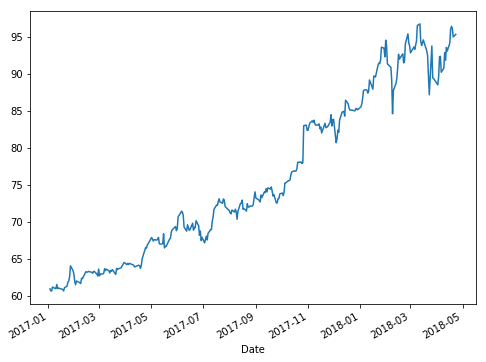

In [60]:
closes_msft.plot(figsize=(8,6))

In [61]:
ret_msft = calc_daily_ret(closes_msft)

## Call Down and Out

### Modelo Normal de Rendimientos

In [62]:
mu = ret_msft.mean()
sigma = ret_msft.std()
r = 0.0225/360
mu, sigma, r

(0.0014128644560560412, 0.012023362107195734, 6.25e-05)

In [63]:
K = 105  # precio de ejercicio
B = 92  # precio de barrera
ndays = (datetime(2018,8,15).date()-datetime(2018,4,23).date()).days
nscen = 100000
dates = pd.date_range('2018-04-23',periods=ndays).astype('str')
sim_ret = pd.DataFrame(sigma*np.random.randn(ndays,nscen)+r,index=dates)
sim_closes = (closes_msft.iloc[-1])*np.exp(sim_ret.cumsum())

In [64]:
barrier = pd.DataFrame(B*np.ones((ndays, nscen)),index=dates)
I = (sim_closes<barrier).cumsum()>0
I

,0,1,2,...,99997,99998,99999
2018-04-23,False,False,False,...,False,False,False
2018-04-24,False,False,False,...,False,False,False
2018-04-25,False,False,False,...,False,False,False
2018-04-26,False,False,False,...,False,False,False
2018-04-27,True,False,False,...,False,False,False
...,...,...,...,...,...,...,...
2018-08-10,True,False,True,...,True,True,True
2018-08-11,True,False,True,...,True,True,True
2018-08-12,True,False,True,...,True,True,True
2018-08-13,True,False,True,...,True,True,True


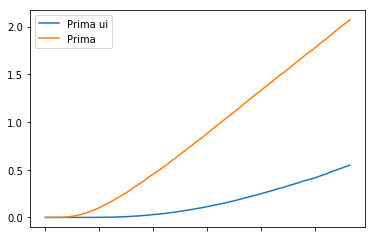

In [65]:
strike = pd.DataFrame(K*np.ones((ndays, nscen)),index=dates)
call = pd.DataFrame({'Prima':np.exp(-r*ndays)*np.fmax(sim_closes-strike,np.zeros((ndays,nscen))).T.mean()},index=dates)
callui = pd.DataFrame({'Prima ui':np.exp(-r*ndays)*(I*np.fmax(sim_closes-strike,np.zeros((ndays,nscen)))).T.mean()},index=dates)

ax = callui.plot();
call.plot(ax=ax);

In [66]:
call.iloc[-1]

Prima    2.072
Name: 2018-08-14, dtype: float64

In [67]:
callui.iloc[-1]

Prima ui    0.547
Name: 2018-08-14, dtype: float64

## Método del histograma

In [68]:
freq, values = np.histogram(ret_msft-mu+r, bins=250)
freq = freq.astype('float32')
prob = freq/np.sum(freq)

In [69]:
K = 105
B = 92
S0 = closes_msft.iloc[-1]
ndays = (datetime(2018,8,15).date()-datetime(2018,4,23).date()).days
nscen = 100000
dates = pd.date_range('2018-04-23',periods=ndays).astype('str')
ret = np.random.choice(values[1:], (ndays,nscen), p = prob)
sim_ret_hist = pd.DataFrame(ret,index=dates)
sim_closes_hist = S0*np.exp(sim_ret_hist.cumsum())

In [70]:
barrier = pd.DataFrame(B*np.ones((ndays, nscen)),index=dates)
I = (sim_closes_hist<barrier).cumsum()>0
I

,0,1,2,...,99997,99998,99999
2018-04-23,False,False,False,...,False,False,False
2018-04-24,False,False,False,...,False,False,False
2018-04-25,False,False,False,...,False,False,False
2018-04-26,False,False,False,...,False,False,False
2018-04-27,False,False,False,...,False,False,False
...,...,...,...,...,...,...,...
2018-08-10,False,False,False,...,True,True,True
2018-08-11,False,False,False,...,True,True,True
2018-08-12,False,False,False,...,True,True,True
2018-08-13,False,False,False,...,True,True,True


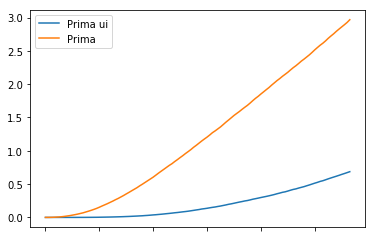

In [71]:
strike = pd.DataFrame(K*np.ones((ndays, nscen)),index=dates)
call = pd.DataFrame({'Prima':np.exp(-r*ndays)*np.fmax(sim_closes_hist-strike,np.zeros([ndays,nscen])).T.mean()},index=dates)
callui = pd.DataFrame({'Prima ui':np.exp(-r*ndays)*(I*np.fmax(sim_closes_hist-strike,np.zeros((ndays,nscen)))).T.mean()},index=dates)

ax = callui.plot();
call.plot(ax=ax);

In [72]:
call.iloc[-1]

Prima    2.967
Name: 2018-08-14, dtype: float64

In [73]:
callui.iloc[-1]

Prima ui    0.686
Name: 2018-08-14, dtype: float64

## Put Up and Out

### Modelo Normal de Rendimientos

In [74]:
mu = ret_msft.mean()
sigma = ret_msft.std()
r = 0.0225/360
mu, sigma, r

(0.0014128644560560412, 0.012023362107195734, 6.25e-05)

In [75]:
K = 85  # precio de ejercicio
B = 105  # precio de barrera
ndays = (datetime(2018,8,15).date()-datetime(2018,4,23).date()).days
nscen = 100000
dates = pd.date_range('2018-04-23',periods=ndays).astype('str')
sim_ret = pd.DataFrame(sigma*np.random.randn(ndays,nscen)+r,index=dates)
sim_closes = (closes_msft.iloc[-1])*np.exp(sim_ret.cumsum())

In [76]:
barrier = pd.DataFrame(B*np.ones((ndays, nscen)),index=dates)
I = (sim_closes>barrier).cumsum()>0
I

,0,1,2,...,99997,99998,99999
2018-04-23,False,False,False,...,False,False,False
2018-04-24,False,False,False,...,False,False,False
2018-04-25,False,False,False,...,False,False,False
2018-04-26,False,False,False,...,False,False,False
2018-04-27,False,False,False,...,False,False,False
...,...,...,...,...,...,...,...
2018-08-10,False,True,True,...,True,False,False
2018-08-11,False,True,True,...,True,False,False
2018-08-12,False,True,True,...,True,False,False
2018-08-13,False,True,True,...,True,False,False


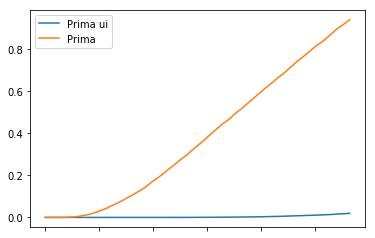

In [77]:
strike = pd.DataFrame(K*np.ones((ndays, nscen)),index=dates)
put = pd.DataFrame({'Prima':np.exp(-r*ndays)*np.fmax(strike-sim_closes,np.zeros((ndays,nscen))).T.mean()},index=dates)
putui = pd.DataFrame({'Prima ui':np.exp(-r*ndays)*(I*np.fmax(strike-sim_closes,np.zeros((ndays,nscen)))).T.mean()},index=dates)

ax = putui.plot();
put.plot(ax=ax);

In [78]:
put.iloc[-1]

Prima    0.937
Name: 2018-08-14, dtype: float64

In [79]:
putui.iloc[-1]

Prima ui    0.019
Name: 2018-08-14, dtype: float64

## Método del Histograma

In [80]:
freq, values = np.histogram(ret_msft-mu+r, bins=250)
freq = freq.astype('float32')
prob = freq/np.sum(freq)

In [81]:
K = 85
B = 105
S0 = closes_msft.iloc[-1]
ndays = (datetime(2018,8,15).date()-datetime(2018,4,23).date()).days
nscen = 100000
dates = pd.date_range('2018-04-23',periods=ndays).astype('str')
ret = np.random.choice(values[1:], (ndays,nscen), p = prob)
sim_ret_hist = pd.DataFrame(ret,index=dates)
sim_closes_hist = S0*np.exp(sim_ret_hist.cumsum())

In [82]:
barrier = pd.DataFrame(B*np.ones((ndays, nscen)),index=dates)
I = (sim_closes_hist>barrier).cumsum()>0
I

,0,1,2,...,99997,99998,99999
2018-04-23,False,False,False,...,False,False,False
2018-04-24,False,False,False,...,False,False,False
2018-04-25,False,False,False,...,False,False,False
2018-04-26,False,False,False,...,False,False,False
2018-04-27,False,False,False,...,False,False,False
...,...,...,...,...,...,...,...
2018-08-10,False,True,False,...,True,True,True
2018-08-11,False,True,False,...,True,True,True
2018-08-12,False,True,False,...,True,True,True
2018-08-13,False,True,False,...,True,True,True


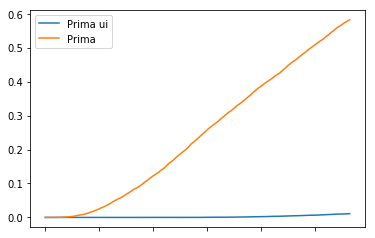

In [83]:
strike = pd.DataFrame(K*np.ones((ndays, nscen)),index=dates)
put = pd.DataFrame({'Prima':np.exp(-r*ndays)*np.fmax(strike-sim_closes_hist,np.zeros([ndays,nscen])).T.mean()},index=dates)
putui = pd.DataFrame({'Prima ui':np.exp(-r*ndays)*(I*np.fmax(strike-sim_closes_hist,np.zeros((ndays,nscen)))).T.mean()},index=dates)

ax = putui.plot();
put.plot(ax=ax);

In [84]:
put.iloc[-1]

Prima    0.582
Name: 2018-08-14, dtype: float64

In [85]:
putui.iloc[-1]

Prima ui    0.011
Name: 2018-08-14, dtype: float64